# <a href="http://codeforces.com/contest/1052/standings">Huawei Honorcup Marathon 1</a>  @ Codeforces
# Eighth place solution, team "now_you_see" 
## Pavel Blinov (blinoff.pavel@gmail.com), Data Scientist at Yandex, Moscow, Russia

1. [Prerequisites](#prer)<br>
    1.1 [Directory structure](#dir)<br>
    1.2 [Libraries](#lib)<br>
    1.3 [Hardware](#hw)<br>
2. [Feature generation](#features)<br>
    2.1 [ECG quality](#ecg_qual)<br>
    There is a cool library called NeuroKit for extracting features from ECG signal. We'll use it for signal quality assess.<br>
    2.2 [Peak features](#peak)<br>
    For this features we find peaks in PPG signals, link min values with max by a straight line (see example plot below) and compute difference between signal values and this line points. For the array of such diffs we compute set of statistics like min, max, median, mean etc. Then such arrays of statistics we average for several peaks.<br>This procedure would be done for pre and post peak part of signal. In such features we can measure the signal form.<br>
    2.3 [Raw signal stat](#raw_stat)<br>
    For each PPG and ECG signals compute some general raw statistics (mean, std, etc) and characteristics (mobility, complexity), user_id for one-hot-encoding, etc. Also for each user we compute its mean SBP and DBP values based on history data.<br>
3. [Hstack all features, CV & predict](#feat_hstack_predict)<br>
At this moment we hstack all features, one hot encode user_id, scale the rest. Eventually there would be 71 features. We'll use SVR with linear kernel (there are only few data point, so better stick to simpler models to preven overfitting) to make CV and predict for the tests. The result would be in A_sbm0.ans, B_sbm0.ans, C_sbm0.ans files<br>
---

<a id="prer"></a>
# Prerequisites
<a id="dir"></a>
## Directory structure
<font color='red'>Before run, please, make sure you directory structure looks like this!</font><br>
```bash
 +--blood-pressure-estimation-data
    +--readme.md
    +--main.ipynb
    +--peakdetect.py
    +--data_train
       +--subj3log127.csv
       +--subj3log128.csv
       +--*.csv
    +--data_test1_blank
       +--subj8log456.csv
       +--subj8log457.csv
       +--*.csv
    +--data_test2_blank
       +--subj1log1.csv
       +--subj1log2.csv
       +--*.csv
```

<a id="lib"></a>
## Libraries
I've run the code with Python 3.6.4 and used folowing libraries:
```python
joblib.__version__=='0.11'
pandas.__version__=='0.20.3'
numpy.__version__=='1.13.3'
sklearn.__version__=='0.19.1'
scipy.__version__=='1.0.0'
seaborn.__version__=='0.8.1'
matplotlib.__version__=='2.1.0'
NeuroKit.__version__=='0.2.7'
```

<a id="hw"></a>
## Hardware
I've run this code on Intel(R) Core(TM) i7-6600U CPU @ 2.60GHz 4 core notebook with 16GB RAM. 500MB of disk space should be enough.<br>

In [1]:
from __future__ import division
from __future__ import print_function
from collections import Counter
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import joblib
from sklearn import svm
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import KFold
from math import sqrt
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from peakdetect import peakdetect

In [156]:
# install NeuroKit package
!pip install https://github.com/neuropsychology/NeuroKit.py/zipball/master

In [3]:
import seaborn as sns
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [14.0, 10.0]
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("hls"))

import neurokit as nk

<a id="features"></a>
# Feature generation

In [4]:
# list all files rom train, valid, test
files = []
for dir_name in ["data_train/", "data_test1_blank/", "data_test2_blank/"]:
    for f_name in os.listdir(dir_name):
        files.append(dir_name+f_name)

<a id="ecg_qual"></a>
## ECG quality

In [27]:
# get Average_Signal_Quality of ECG signal (unfortunately this feature not exact from run to run, but very similar)
neuro_features = []
counter = 0
for file_name in files:
    df = pd.read_csv(file_name)
    try:
        bio = nk.bio_process(ecg=df.iloc[:, 1].values, sampling_rate=500)
        signal_quality = [ bio["ECG"]["Average_Signal_Quality"] ]
    except:
        signal_quality = [0]
    neuro_features.append( signal_quality )
    counter += 1
    if counter%100==0:
        print (counter)
        #break
neuro_features = np.array(neuro_features)
print (neuro_features.shape)
neuro_features[np.isinf(neuro_features)] = 0
neuro_features[np.isnan(neuro_features)] = 0

In [98]:
joblib.dump(neuro_features, "neuro_features.pkl")

In [6]:
neuro_features = joblib.load("neuro_features.pkl")
print (neuro_features.shape)

(1737, 1)


<a id="peak"></a>
## Peak features

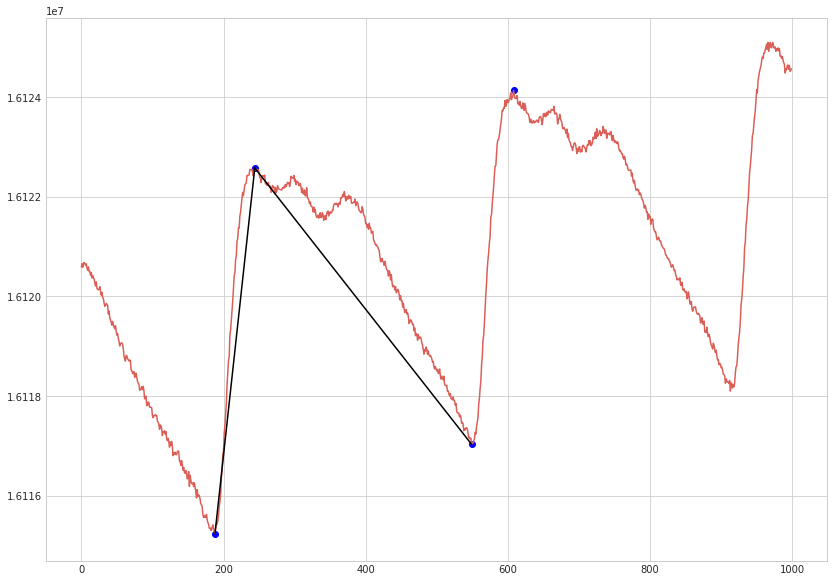

In [101]:
df = pd.read_csv("data_train/subj7log402.csv")
start = 6000
peaks = peakdetect(df.iloc[start:start+1000,0].values, lookahead=100)
points = peaks[0]+peaks[1]
points = np.array(points)

p0 = peaks[1][min_index]
p1 = np.array([i[0] for i in peaks[0]])-p0[0]
tmp_min = np.min(p1[p1>0])
max_index = np.argmax(p1==tmp_min)
p1 = peaks[0][max_index]
p2 = peaks[1][min_index+1]
p3 = peaks[0][max_index+1]

plt.plot(df.iloc[start:start+1000,0].values)
plt.scatter(points[:,0], points[:,1], marker="o", c="b")
#plt.scatter([p0[0], p1[0], p2[0], p3[0]], [p0[1], p1[1], p2[1], p3[1]], marker="o", c="b")
plt.plot([p0[0],p1[0]],[p0[1],p1[1]],'k-')
plt.plot([p1[0],p2[0]],[p1[1],p2[1]], 'k-')
plt.show()

In [102]:
# find peak
def get_post_peak_vector(start):
    peaks = peakdetect(df.iloc[start:start+2000,0].values, lookahead=100)
    points = peaks[0]+peaks[1]
    points = np.array(points)

    p0, p1 = peaks[0][0], peaks[1][0]
    if p0[1]>p1[1] and p1[0]>p0[0]: ##max min case
        pass
    else: ##min max case
        p1 = peaks[1][1]
    
    ydiff = p0[1]-p1[1]
    xdiff = p0[0]-p1[0]

    k = ydiff/xdiff
    b = p0[1] - k*p0[0]

    arr = [] # array of differences between line and signal value
    for idx, value in enumerate(df.iloc[start+p0[0]:start+p1[0],0]):
        x = p0[0]+idx
        y = k*x+b
        arr.append(value-y)
    arr = np.array(arr)
    return [np.mean(arr), np.max(arr), np.std(arr), np.median(arr), np.sum(arr),
            np.sum(arr<0), np.sum(arr<0)/arr.shape[0], np.max(arr)/np.mean(arr),
            np.sum(arr>=0)/arr.shape[0], p0[1]-p1[1], k,
            stats.skew(arr), stats.kurtosis(arr), np.argmax(arr)]

def get_pre_peak_vector(start):
    peaks = peakdetect(df.iloc[start:start+2000,0].values, lookahead=100)
    points = peaks[0]+peaks[1]
    points = np.array(points)

    p0 = peaks[1][0]
    i = 0
    while peaks[0][i][0]<p0[0]:
        i += 1
    p1 = peaks[0][i]
    
    ydiff = p0[1]-p1[1]
    xdiff = p0[0]-p1[0]
    k = ydiff/xdiff
    b = p0[1] - k*p0[0]
    
    arr = []
    for idx, value in enumerate(df.iloc[start+p0[0]:start+p1[0],0]):
        x = p0[0]+idx
        y = k*x+b
        arr.append(value-y)
    arr = np.array(arr)
    return [np.mean(arr), np.max(arr), np.std(arr), np.median(arr), np.sum(arr),
            np.sum(arr<0), np.sum(arr<0)/arr.shape[0], np.max(arr)/np.mean(arr),
            np.sum(arr>=0)/arr.shape[0], p0[1]-p1[1], k,
            stats.skew(arr), stats.kurtosis(arr), np.argmax(arr)]

In [155]:
peak_features = []
counter = 0
for file_name in files:
    print (counter, file_name)
    df = pd.read_csv(file_name)
    peaks = peakdetect(df.iloc[4000:6000,0].values, lookahead=100)
    points = peaks[0]+peaks[1]
    points = np.array(points)
    
    if points.shape[0]==0:
        pulse_interval = .81 # default value for pulse interval
    else:
        min1 = peaks[1][0]
        max1 = peaks[0][0]
        min2 = peaks[1][1]
        pulse_interval = (min2[0]-min1[0])/500
    
    if len(set(df.iloc[:,0].values))==1: # skip constant cases
        post_peak_features, pre_peak_features = [0]*14, [0]*14
    else:
        post_peak_features = []
        for k in range(4000, 10000, 1000): # repeat for a few start positions
            post_peak_features.append( get_post_peak_vector(k) )
        post_peak_features = np.mean(post_peak_features, axis=0)
        
        pre_peak_features = []
        for k in range(8000, 14000, 1000): # repeat for a few start positions
            pre_peak_features.append( get_pre_peak_vector(k) )
        pre_peak_features = np.mean(pre_peak_features, axis=0)
    
    peak_features.append( [pulse_interval]+list(post_peak_features)+list(pre_peak_features) )
    counter += 1
peak_features = np.array(peak_features)
print (peak_features.shape)

In [104]:
joblib.dump(peak_features, "peak_features.pkl")

['peak_features.pkl']

In [105]:
peak_features = joblib.load("peak_features.pkl")
print (peak_features.shape)

(1737, 29)


<a id="raw_stat"></a>
### Raw signal stat

In [106]:
user2hist = {} # collect history of mesurements for each user
def get_features(file_name):
    user_id = int(file_name.split("/")[1].split("log")[0][4:])
    
    df = pd.read_csv(file_name)
    before = df.shape[0]
    mask = np.array( [len(str(i))==4 for i in df.iloc[:,1].values] ) # get mask to filter out invalid signal points
    df = df.iloc[mask, :]
    
    dj = df.iloc[:,1].values[1:]-df.iloc[:,1].values[:-1]
    gk = dj[1:]-dj[:-1]
    s0 = np.power( np.sum(np.power(df.iloc[:,1].values, 2))/(df.shape[0]), .5 )
    s1 = np.power( np.sum(np.power(dj, 2))/(df.shape[0]-1), .5 )
    # compute mobility and complexity of a ECG signal
    mobility = (s1/s0)
    complexity = np.power( np.sum(np.power(gk, 2))/(df.shape[0]-2), .5 )
    
    peaks = peakdetect(df.iloc[:,0], lookahead=100)
    max_values = [point[1] for point in peaks[0]]
    min_values = [point[1] for point in peaks[1]]
    
    # compute statistics based on difference in peaks for 
    diff = []
    for i in range(min(len(peaks[0]), len(peaks[1]))):
         diff.append( np.abs(peaks[0][i][1]-peaks[1][i][1]) )
    if len(diff)>0:
        diff = [np.mean(diff), np.max(diff), np.std(diff), np.median(diff)]
    else:
        diff = [0, 0, 0, 0]
    
    vector = [
        user_id, # for ohe
        np.mean(df.iloc[:, 0]), np.max(df.iloc[:, 0]), np.std(df.iloc[:, 0]), np.median(df.iloc[:, 0]),
        np.mean(df.iloc[:, 1]), np.max(df.iloc[:, 1]), np.std(df.iloc[:, 1]), np.median(df.iloc[:, 0]),
    ]+diff+[mobility, complexity]

    if not user_id in user2hist:
        user2hist[user_id] = []
    user2hist[user_id].append( df.columns.values.astype(float).astype(int) )
    return df.columns.values.astype(float).astype(int), vector

In [154]:
all_X, all_y, all_ids = [], [], []
for file_name in files:
    print (file_name)
    y_values, vector = get_features(file_name)
    all_X.append(vector)
    all_y.append(y_values)
    all_ids.append(file_name)
    #break
all_X = np.array(all_X)
print (all_X.shape)
all_y = np.array(all_y)
print (all_y.shape)
all_ids = np.array(all_ids)
print (all_ids.shape)

In [112]:
# compute user mean SBP and DBP based on history measurements
user2stat = {}
for k in user2hist:
    h = np.array(user2hist[k])
    mask = h[:,0]>0
    h = h[mask,:]
    user2stat[k] = [
        np.mean(h[:,0]), np.mean(h[:,1]),
    ]

In [113]:
stat_X = []
for k in [int(s.split("/")[1].split("log")[0][4:]) for s in all_ids]:
    stat_X.append( user2stat[k] )
stat_X = np.array(stat_X)

<a id="feat_hstack_predict"></a>
# Hstack all features, CV & predict

In [114]:
# hstack all type of features
all_X = np.hstack( (all_X, neuro_features, peak_features, stat_X) )
print (all_X.shape)
all_X[np.isnan(all_X)] = 0

(1737, 47)


In [115]:
enc = OneHotEncoder()
# one hot encode user_id
ohe_part = enc.fit_transform(all_X[:,0].reshape((-1,1))).toarray()

In [116]:
scaler = StandardScaler()
# scale the rest of the features
scale_part = scaler.fit_transform(all_X[:, 1:])

In [117]:
# and again combine in a single feature array
all_X = np.hstack( (ohe_part, scale_part) )
print (all_X.shape)

(1737, 71)


In [118]:
# split for train
mask = all_y[:,0]>0
X = all_X[mask, :]
print (X.shape)
y = all_y[mask, :]
print (y.shape)
ids = all_ids[mask]

(1058, 71)
(1058, 2)


In [119]:
# split for test
X_test = all_X[~mask, :]
print (X_test.shape)
ids_test = all_ids[~mask]
print (ids_test.shape)

(679, 71)
(679,)


In [122]:
# make CV loop
sss = KFold(n_splits=5, shuffle=True, random_state=369)
scores = []
for train_index, test_index in sss.split(X, y):
    X_train, X_cv = X[train_index,:], X[test_index,:]
    ids_train, ids_cv = ids[train_index], ids[test_index]
    
    clf = svm.SVR(kernel='linear', C=.5)
    
    y_trains, y_cv = y[train_index, 0], y[test_index, 0]
    clf = clf.fit(X_train, y_trains)
    pred2s = clf.predict(X_cv)
    rms_sbp = sqrt(metrics.mean_squared_error(y_cv, pred2s))
    
    y_train, y_cv = y[train_index, 1], y[test_index, 1]
    # we predict dpb with sbp (as we know it at this point)
    clf = clf.fit(np.hstack( (X_train, y_trains.reshape((-1,1)) ) ) , y_train)
    pred2 = clf.predict( np.hstack((X_cv, pred2s.reshape((-1,1)))) )
    rms_dbp = sqrt(metrics.mean_squared_error(y_cv, pred2))
    
    score = 100*rms_sbp+200*rms_dbp
    print (score)
    scores.append(score)
print (np.mean(scores), np.std(scores))

2220.0573142883795
2036.3118998824525
2121.185525067452
2080.4257507628804
2292.1328697570657
2150.02267195 93.4939694435


In [123]:
# 2150.13855025 91.501470142 2037.538
# 2146.92968666 92.6114706872 2039.455
# 2172.92464465 107.414204039 2070
# 2168.15528433 109.755820144 2071.006
# 2166.52696427 110.331407476 2078.081
# 2222.77552202 98.7365540763 2115.483
# 2281.55159618 139.049364005 2115.036
# 2286.88530473 137.81021606 2118.786
# 2222.29477521 126.665196954
# 2225.77290634 123.178234491 2127.202
# 2225.78128932 123.221700704 2128.029
# 2228.03274912 122.904867665 2130.736
# 2224.73184762 122.715484006 2133.523
# 2223.02045858 124.995201884 2147.972
# 2227.90276896 124.3557202 2151.422
# 2225.88852115 125.635438271 2155.313
# 2241.95363076 108.327866983 2155.493 ?
# 2222.52629846 113.995236348 2176.546
# 2223.67430522 127.736783466 2161.06
# 2227.49785482 128.358948551 2160.241 / 2213.66231286 131.740318893 2172.295
# 2230.2540803 120.931303271 2227.714
# 2232.67180125 130.564352789 2199.162

In [124]:
# train on all set and predict
clf = clf.fit(X, y[:, 0])
pred2_sbp = clf.predict(X_test)

clf = clf.fit(np.hstack((X, y[:,0].reshape((-1,1)))), y[:, 1])
pred2_dbp = clf.predict( np.hstack((X_test, pred2_sbp.reshape((-1,1)))) )

In [127]:
# save the result in data frame
out_df = pd.DataFrame({"id":ids_test, "sbp":pred2_sbp, "dbp":pred2_dbp})
print (out_df.shape)

(679, 3)


In [128]:
# and append a compliment as of the rules
compliment_df = pd.DataFrame({"id":ids, "sbp":y[:,0], "dbp":y[:,1]})
print (compliment_df.shape)

out_df = pd.concat((out_df, compliment_df))
print (out_df.shape)

(1058, 3)
(1737, 3)


In [129]:
out_df.head(3)

dbp                                 id         sbp
0  76.128929  data_test1_blank/subj12log743.csv  109.077383
1  81.498489  data_test1_blank/subj15log986.csv  111.359147
2  75.093014  data_test1_blank/subj15log949.csv  107.691764

In [130]:
# leave only file name as id and append part split column
out_df['part'], out_df['id'] = out_df['id'].str.split('/', 1).str

In [132]:
# cast values to int
out_df.dbp = out_df.dbp.round().astype(int)
out_df.sbp = out_df.sbp.round().astype(int)

In [133]:
# and save all results to files
mask = out_df.part.values=="data_test1_blank"
(out_df[["id", "sbp", "dbp"]]).iloc[mask,:].to_csv("B_sbm0.ans", index=False, header=False)

mask = out_df.part.values=="data_test2_blank"
(out_df[["id", "sbp", "dbp"]]).iloc[mask,:].to_csv("C_sbm0.ans", index=False, header=False)

mask = out_df.part.values=="data_train"
(out_df[["id", "sbp", "dbp"]]).iloc[mask,:].to_csv("A_sbm0.ans", index=False, header=False)